In [ ]:
import torch
import torch.optim as optim
import sys, os
from torch import nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.utils.data as data
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def create_dataset(dataset, windowlen):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    # feature_scalling
    sc = StandardScaler()
    signal = sc.fit_transform(dataset)
    X = []
    for i in range(int(len(signal)/windowlen)):
        feature = signal[i*windowlen:(i+1)*windowlen]
        X.append(feature)
    return torch.tensor(np.array(X)).float()

def data_generator( batch_size, windowlen):
    print('Loading CHB-MIT Interical and preictal dataset...')
    preictal_data = pd.read_csv('/content/drive/MyDrive/data/ictal_data.csv')
    ictal_data = pd.read_csv('/content/drive/MyDrive/data/preictal_data.csv')

    class1 = create_dataset(preictal_data, windowlen=windowlen)
    y_1= torch.zeros(class1.shape[0],1)

    class2 = create_dataset(ictal_data, windowlen=windowlen)
    y_2 = torch.ones(class2.shape[0],1)

    datasets = torch.cat((class1, class2),0)
    labels = torch.cat((y_1, y_2), 0)

    X_train, X_test, y_train, y_test = train_test_split(datasets, labels, test_size=0.25, shuffle=True, random_state=42)
    print(f" Shape of the Training data is {X_train.shape,}, and Testing data is {X_test.shape}" )

    train_loader = data.DataLoader(data.TensorDataset(X_train, y_train),  batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(data.TensorDataset(X_test, y_test),  batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [ ]:
batch_size =50
window_length = 512
train_loader, test_loader = data_generator(batch_size, window_length)

Loading CHB-MIT Interical and preictal dataset...
 Shape of the Training data is (torch.Size([3070, 512, 23]),), and Testing data is torch.Size([1024, 512, 23])


In [ ]:
lr=0.001
d_dim=23
heads=2
epochs=10
embed_dim=40
num_layers=2
dropout=0.1
log_interval=10
n_classes = 1  ## For Binary class
sequence_length = window_length


In [ ]:
class Embedding(nn.Module):
    def __init__(self, d_dim, embed_dim):
        super(Embedding, self).__init__()
        self.d_dim = d_dim
        self.embed_dim = embed_dim
        self.embed = nn.Linear(self.d_dim, self.embed_dim)

    def forward(self, x):
        return self.embed(x)



def positional_embedding(sequence_length, embed_dim):
    '''
    Args:
        sequence_length: length of the input Sequence
        embed_dim: Embedding dimension
    '''
    pe = torch.zeros(sequence_length, embed_dim)
    for i in range(sequence_length):
        for j in range(embed_dim):
            pe[i][j] = np.sin(i / (10000 ** (j / embed_dim))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / embed_dim)))

    return pe.to(device)




## Multi-head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, n_heads):
        super(MultiHeadAttention, self).__init__()
        """
        Args:
            embed_dim: dimension of the embedding vector output
            n_heads: number of self attention heads
        """
        self.embed_dim = embed_dim
        self.n_heads = n_heads

        assert self.embed_dim% self.n_heads == 0, 'n_heads is not a factor of Embed_dim '
        self.single_head_dim = int(self.embed_dim/self.n_heads)

        # Defining key, query, and value matrixes
        self.key_mat = nn.Linear(self.single_head_dim, self.single_head_dim, bias = False)
        self.query_mat = nn.Linear(self.single_head_dim, self.single_head_dim, bias = False)
        self.value_mat = nn.Linear(self.single_head_dim, self.single_head_dim, bias = False)
        self.W_o_mat = nn.Linear(self.n_heads*self.single_head_dim, self.embed_dim, bias = False)


    def forward (self, key, query, value, need_weights=False): # batch_size x sequence_length x embedding_dim
        '''
        Args:
            key: key vector
            query: query vector
            value: value vector

        returns:
            output vectors from multihead attention

        '''
        batch_size = key.shape[0]
        sequence_length = key.shape[1]

        # Changing dimensions according to heads
        key = key.view(batch_size, sequence_length, self.n_heads, self.single_head_dim)
        query = query.view(batch_size, sequence_length, self.n_heads, self.single_head_dim)
        value = value.view(batch_size, sequence_length, self.n_heads, self.single_head_dim)

        # Computing key, query, and value vectors
        K = self.key_mat(key)
        Q = self.query_mat(query)
        V = self.value_mat(value)

        # Transposing the matrixes to find the multihead self attention

        K = K.transpose(1,2)
        Q = Q.transpose(1,2)
        V = V.transpose(1,2)

        # Attention computation
        # adjusting key for matrix multiplication
        K_adj = K.transpose(-1,-2) # (batch_size, n_heads, single_head_dim, sequence_length)

        product = Q@K_adj

        # scaling the product
        product = product/self.single_head_dim**0.5

        # normalizing the product
        scores = F.softmax(product, dim = -1)

        # Computing the self attention
        attn = scores@V

        # Concatenated output
        concat = attn.transpose(1,2).contiguous().view(batch_size, sequence_length, self.n_heads*self.single_head_dim)

        output = self.W_o_mat(concat)

        return output


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads):
        super(TransformerBlock, self).__init__()

        # First layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        # Multi-head attention

        self.msa = MultiHeadAttention(embed_dim, n_heads)

        # Second layer Normalization
        self.norm2 = nn.LayerNorm((embed_dim))

        # Encoder Multilayer perceptron
        self.feed_forward = nn.Sequential(nn.Linear(embed_dim, embed_dim)
                                          ,nn.ReLU())
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x1):

        x = self.norm1(x1)

        attention = self.msa(x,x,x, need_weights=False) #  Multi-head attention
        attention = attention+x # Residual Connection
        out = self.dropout1(attention)

        out = self.norm2(out)
        out = self.feed_forward(out)+out # Feed-forward with residual connection

        return self.dropout2(out)



class TransformerEncoder(nn.Module):
    def __init__(self, sequence_length, embed_dim,d_dim, n_heads, num_layers, pos_enc):
        super(TransformerEncoder, self).__init__()

        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.d_dim = d_dim
        self.sequence_length = sequence_length
        self.pos_enc = pos_enc

        #self.tokenizer = Tokenizer()
        self.embed = Embedding(self.d_dim, self.embed_dim)

        # positional Embedding


        self.layers = nn.ModuleList([TransformerBlock(self.embed_dim, self.n_heads)
                                    for i in range(num_layers)])

        self.fc1 = nn.Linear(self.sequence_length*self.embed_dim, self.embed_dim)
        self.dropout3 = nn.Dropout(0.1)
    def forward(self, x):
        #tokens = self.tokenizer(x)
        out = self.embed(x)
        if self.pos_enc:
            out += positional_embedding(self.sequence_length, self.embed_dim)

        for layer in self.layers:
            out = layer(out)
        # Attention based pooling
        #attn = self.attn(out)
        #attention_out = attn.transpose(2,1)@out

        # Avergae pooling
        representation = torch.flatten(out, start_dim=1)
        representation = self.fc1(representation)
        representation = self.dropout3(representation)
        return representation

In [ ]:
class Vanilla_Transformer(nn.Module):
    def __init__(self, sequence_length, embed_dim, d_dim, n_heads, num_class, num_layers, pos_enc= False):
        super(Vanilla_Transformer, self).__init__()

        self.Trans = TransformerEncoder(sequence_length,
            embed_dim,d_dim, n_heads, num_layers, pos_enc)
        self.linear = nn.Linear(embed_dim, num_class)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.Trans(x)
        out = self.sigmoid(self.linear(out))
        return out


In [ ]:
model =  Vanilla_Transformer(sequence_length=512, embed_dim= 30,d_dim=23, n_heads=2, num_class=1,num_layers=2, pos_enc= False).to(device)

In [ ]:
model_name = "Model_{}_dim_{}_heads_{}_lr_{}_dropout_{}".format(
            'VT',embed_dim, heads, lr, dropout)

message_filename =  'r_' + model_name + '.txt'
model_filename =  'm_' + model_name + '.pt'
with open(message_filename, 'w') as out:
    out.write('start\n')


def output_s(message, save_filename):
    print (message)
    with open(save_filename, 'a') as out:
        out.write(message + '\n')



In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr)

def train(ep):
    targets = list()
    preds = list()
    train_loss = 0
    correct = 0

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()

        optimizer.step()
        train_loss += loss
        pred = output.round()
        correct += (pred== target).sum().item()
        targets += list(target.detach().cpu().numpy())
        preds += list(pred.detach().cpu().numpy())
        acc = 100. * correct / ((batch_idx+1) * batch_size)

        if batch_idx > 0 and batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.2f} \t Acc: {:.2f}".format(
                ep, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()/(batch_idx),acc))

    return 100. * correct / len(train_loader.dataset), train_loss.item()/batch_size,


## Leeanable parameters counts ###
def test():
    model.eval()

    targets = list()
    preds = list()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.round()
            correct += (pred== target).sum().item()
            targets += list(target.detach().cpu().numpy())
            preds += list(pred.detach().cpu().numpy())

        Acc = 100. * correct / len(test_loader.dataset)
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.3f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), Acc))
        #output_s(message, message_filename)
        return targets, preds, Acc, test_loss

#model_total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# In[112]:

Train Epoch: 1 [500/3070 (16.13%)]	Loss: 1.65 	 Acc: 50.91
Train Epoch: 1 [1000/3070 (32.26%)]	Loss: 1.45 	 Acc: 50.95
Train Epoch: 1 [1500/3070 (48.39%)]	Loss: 1.32 	 Acc: 52.58
Train Epoch: 1 [2000/3070 (64.52%)]	Loss: 1.25 	 Acc: 53.02
Train Epoch: 1 [2500/3070 (80.65%)]	Loss: 1.18 	 Acc: 53.80
Train Epoch: 1 [3000/3070 (96.77%)]	Loss: 1.11 	 Acc: 54.07

Test set: Average loss: 0.016, Accuracy: 634/1024 (61.91%)

Train Epoch: 1, Train loss: 1.3466, Time taken: 2.7179, Train Accuracy: 54.2020, Test loss: 0.0155, Test Accuracy: 61.9141
Train Epoch: 2 [500/3070 (16.13%)]	Loss: 0.58 	 Acc: 74.91
Train Epoch: 2 [1000/3070 (32.26%)]	Loss: 0.57 	 Acc: 73.33
Train Epoch: 2 [1500/3070 (48.39%)]	Loss: 0.56 	 Acc: 73.48
Train Epoch: 2 [2000/3070 (64.52%)]	Loss: 0.56 	 Acc: 73.32
Train Epoch: 2 [2500/3070 (80.65%)]	Loss: 0.54 	 Acc: 73.80
Train Epoch: 2 [3000/3070 (96.77%)]	Loss: 0.54 	 Acc: 74.07

Test set: Average loss: 0.013, Accuracy: 741/1024 (72.36%)

Train Epoch: 2, Train loss: 0.6557, T

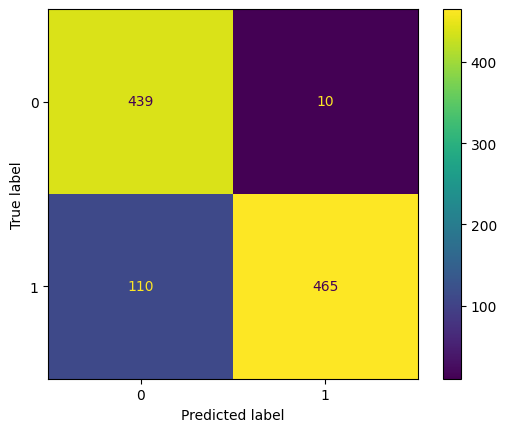

In [ ]:
if __name__ == "__main__":
    exec_time = 0
    for epoch in range(1, epochs+1):
        start = time.time()
        train_acc, train_loss = train(epoch)
        end = time.time()
        t = end-start
        exec_time+= t
        preds, targets, test_acc, test_loss = test()
        message = ('Train Epoch: {}, Train loss: {:.4f}, Time taken: {:.4f}, Train Accuracy: {:.4f}, Test loss: {:.4f}, Test Accuracy: {:.4f}' .format(
                epoch, train_loss, t, train_acc, test_loss, test_acc))
        output_s(message, message_filename)

        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if epoch%(epochs)==0:
            print('Total Execution time for training:',exec_time)
            preds = np.array(preds)
            targets = np.array(targets)
            conf_mat= confusion_matrix(targets, preds)
            disp = ConfusionMatrixDisplay(confusion_matrix= conf_mat)
            disp.plot()
            print(classification_report(targets, preds, digits=4))